In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random

In [111]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score

In [112]:
# plot/colors definitions
cpath = '/n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana'
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use('dark_background')

In [113]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='cubehelix', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred,name):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    fig.savefig(data_loc +name+'.pdf', bbox_inches='tight')

In [114]:
## for males

In [115]:
## upload data frame females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/longtogeny_musages_mtx_all.parquet')
mdf_all = pd.read_parquet(path)
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/longtogeny_musages_mtx_most_used.parquet')
mdf = pd.read_parquet(path)

In [116]:
# remove bad datapoint
bad_sessions = [376]
#bad_sessions = [285, 354]
#bad_session=[221, 228]
#bad_syllable=[44,89]
bad_syllable=[44]
#bad_mouse='04_01'
#temp = mdf.loc[~mdf.index.isin(list(bad))]
mdf.drop(bad_sessions, level=0, axis=0, inplace=True)
#newdf.drop(bad_mouse, level=1, axis=0, inplace=True)
mdf.drop(bad_syllable, axis=1, inplace=True)

In [117]:
## decoder

In [118]:
# choose a model
clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 250)
#clf = LinearRegression()

# choose cross validation scheme
#cv = LeaveOneOut()
#cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
cv=5

#number of iterations for shuffle
it=100

In [119]:
#for males
ymale = mdf.index.get_level_values(0).to_numpy()
Xmale= mdf.to_numpy()
Xmale = np.log(Xmale + 1e-6) # convert to linear

In [120]:
#on pcs
pca = PCA(n_components=10)
pcs=pca.fit_transform(np.log(mdf + 1e-6))
ages = mdf.index.get_level_values(0)
pc_df = pd.DataFrame(pcs)
pc_df['age'] = ages

ymale = pc_df['age']
xmale=pc_df.drop('age',axis=1).to_numpy()

In [121]:
#for males
y_pred = cross_val_predict(clf, Xmale, ymale, cv=cv)
acc=np.mean(np.mean(cross_val_score(clf, Xmale, ymale, cv=cv)))
ysh_score=[]
ysh=[]
ysh_predict=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(ymale)
    y_pred_temp = cross_val_predict(clf, Xmale, ysh_temp, cv=cv)
    y_score_temp = cross_val_score(clf, Xmale, ysh_temp, cv=cv)
    ysh.extend(ysh_temp)
    ysh_predict.extend(y_pred_temp)
    ysh_score.append(np.mean(y_score_temp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:57<00:00,  2.97s/it]


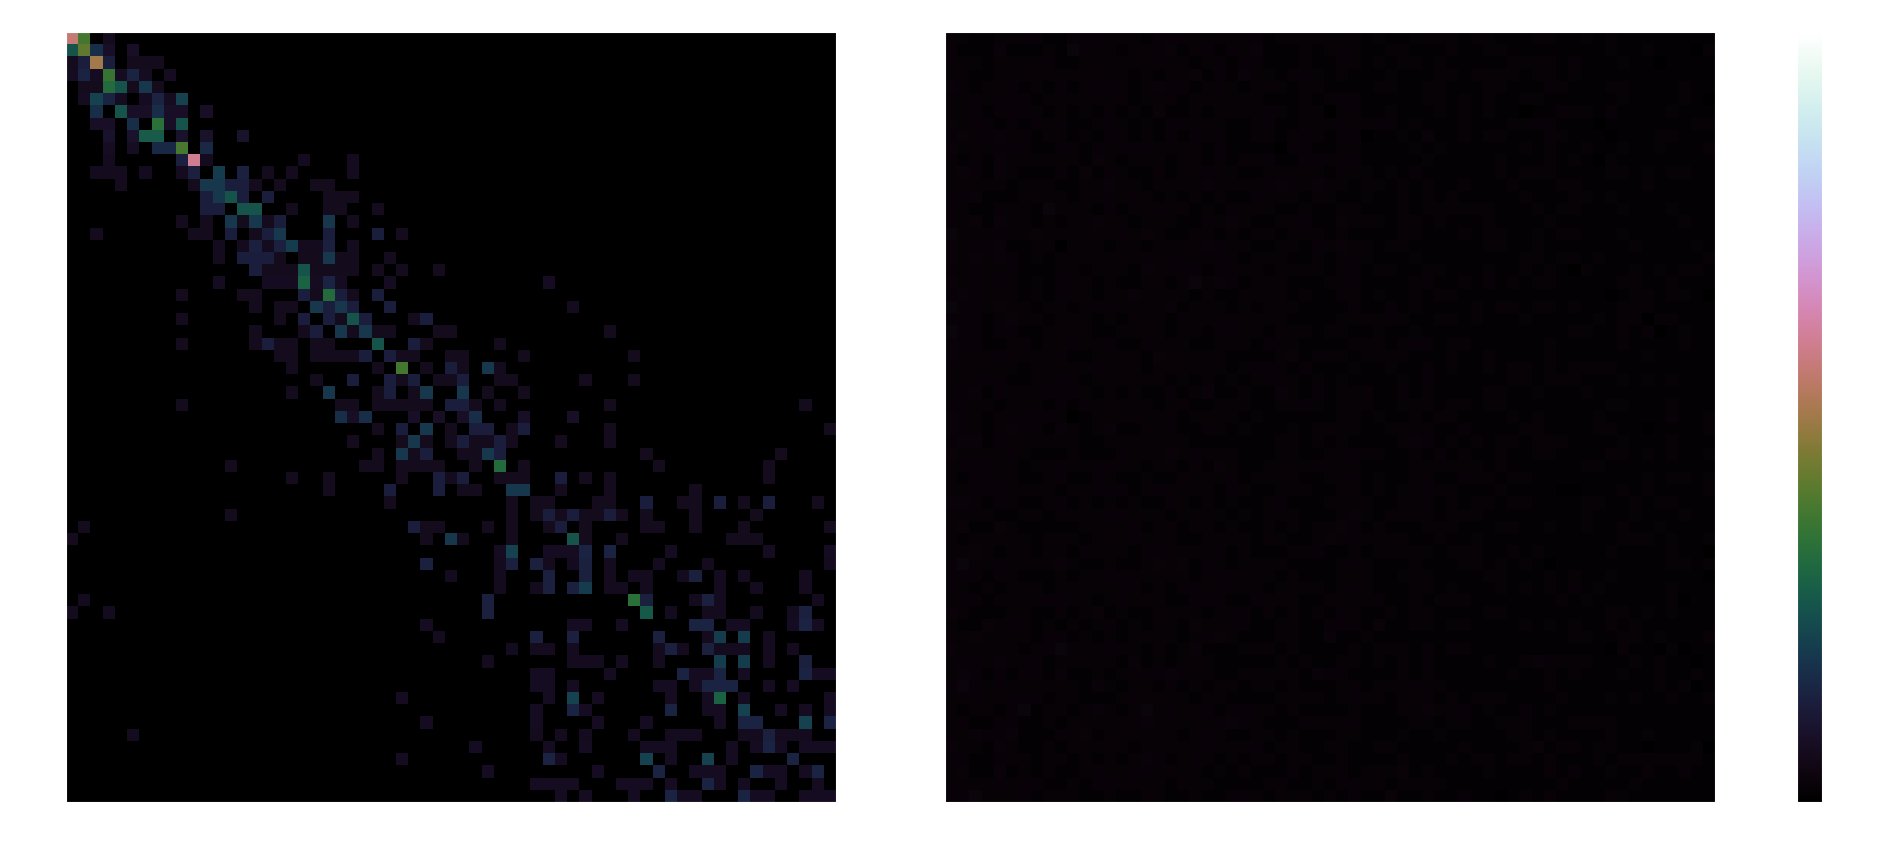

In [122]:
# plot confusion matrix
decoder ='long_age_decoder_males'
plot_cm(ymale,y_pred,ysh,ysh_predict,decoder+'_confusion')

In [123]:
## add plotting accuracy and shuffle with boxplot

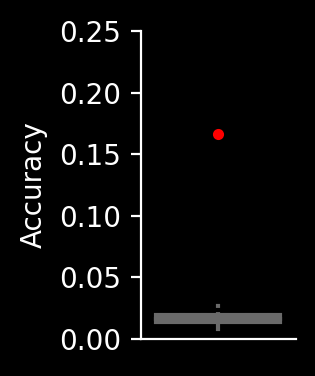

In [124]:
# plot accuracy
shuff_v=pd.DataFrame()
true_acc=pd.DataFrame()
shuff_v['shacc'] = ysh_score
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.boxplot(data=shuff_v['shacc'], showfliers=False, showcaps=False)
ax.plot(0, acc, 'r.')
plt.xticks(ticks=[])
ax.set(ylabel='Accuracy')
plt.ylim([0,0.25])
plt.axhline(y=shuff_v['shacc'].quantile(.95), xmin=0, xmax=1, ls='--', c='k') #plot threshold for significance 
sns.despine()
#fig.savefig(data_loc +decoder+'accuracy.pdf', bbox_inches='tight')

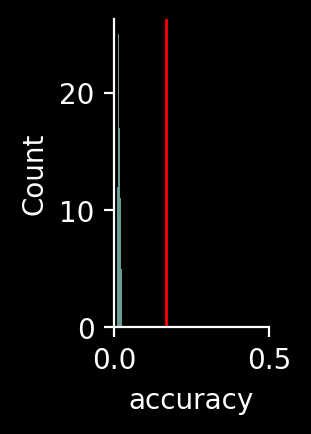

In [125]:
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.histplot(data=shuff_v['shacc'], fill=True, element='step', lw=0)
ax.axvline(acc, color='r', lw=1)
#plt.xticks(ticks=[])
ax.set(ylabel='Count')
ax.set(xlabel='accuracy')
plt.xlim([0,0.5])
sns.despine()
fig.savefig(data_loc +decoder+'accuracy.pdf', bbox_inches='tight')

In [126]:
# plot accuracy

In [127]:
##  predict week without averaging over sessions (no averaging)

In [128]:
days =mdf.index.get_level_values(0).to_numpy()
ymale = np.floor(days/7).astype(int)

In [129]:
#for males
y_pred = cross_val_predict(clf, Xmale, ymale, cv=cv)
acc=np.mean(np.mean(cross_val_score(clf, Xmale, ymale, cv=cv)))
ysh_score=[]
ysh=[]
ysh_predict=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(ymale)
    y_pred_temp = cross_val_predict(clf, Xmale, ysh_temp, cv=cv)
    y_score_temp = cross_val_score(clf, Xmale, ysh_temp, cv=cv)
    ysh.extend(ysh_temp)
    ysh_predict.extend(y_pred_temp)
    ysh_score.append(np.mean(y_score_temp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:03<00:00,  3.04s/it]


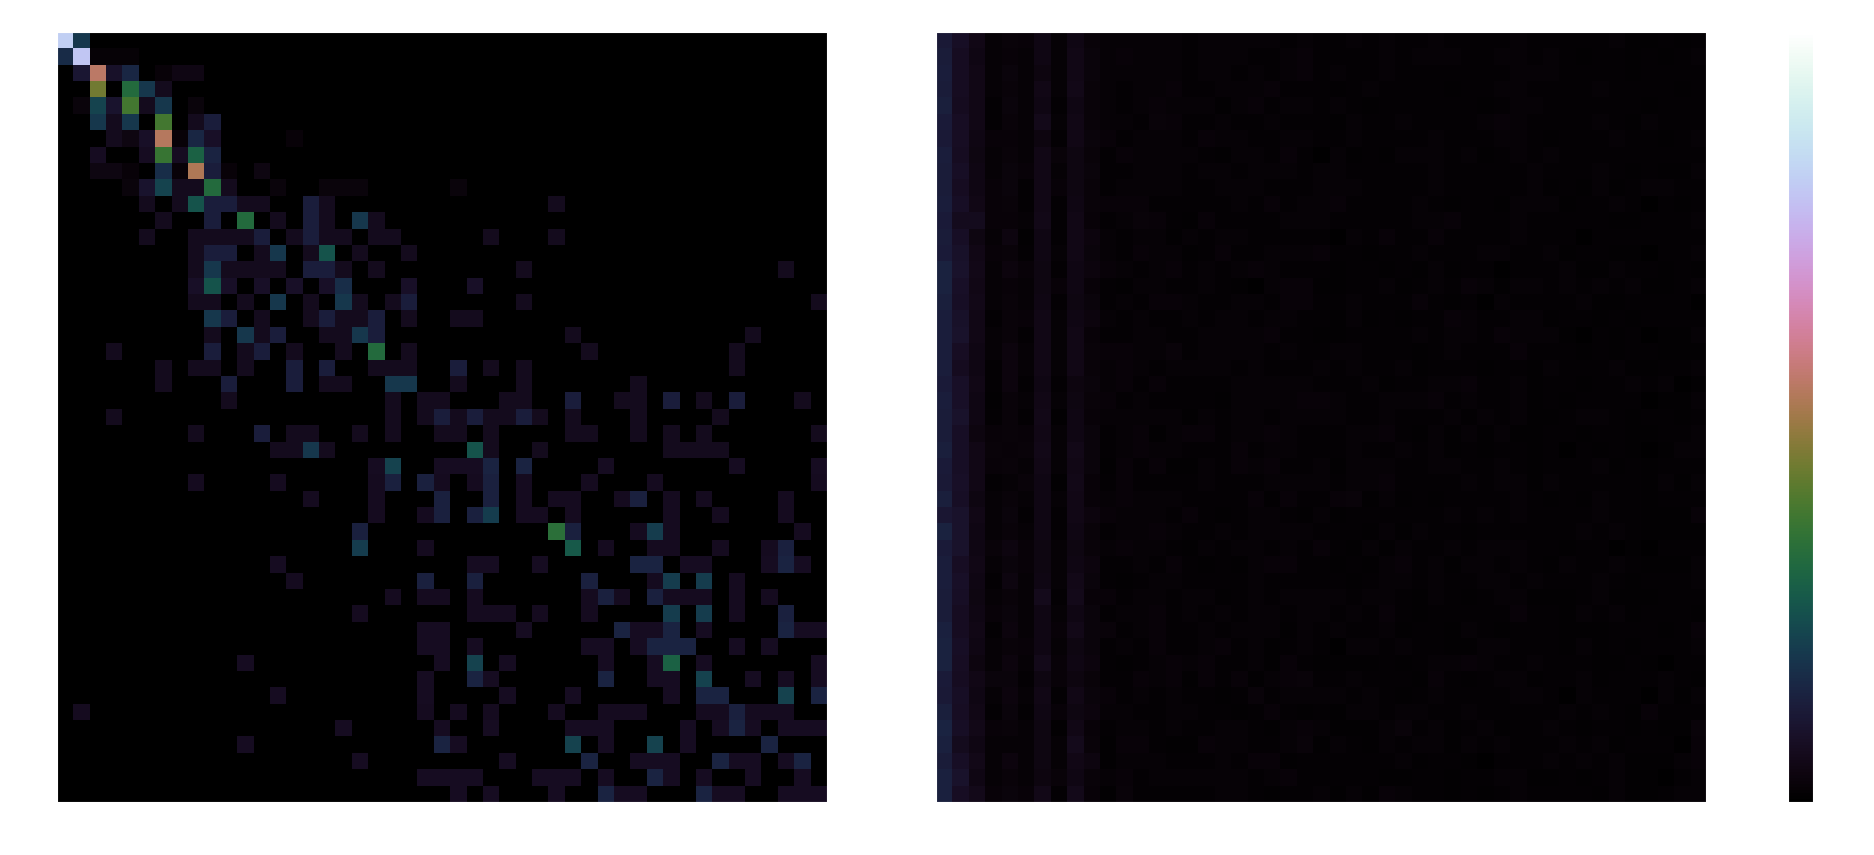

In [130]:
# plot confusion matrix
decoder ='long_age_decoder_males_wks'
plot_cm(ymale,y_pred,ysh,ysh_predict,decoder+'_confusion')

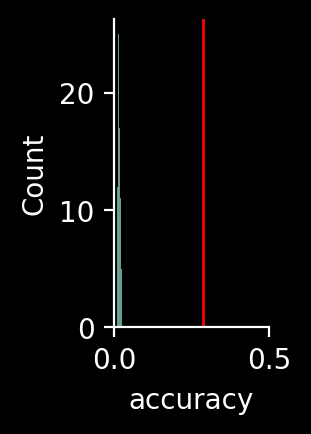

In [131]:
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.histplot(data=shuff_v['shacc'], fill=True, element='step', lw=0)
ax.axvline(acc, color='r', lw=1)
#plt.xticks(ticks=[])
ax.set(ylabel='Count')
ax.set(xlabel='accuracy')
plt.xlim([0,0.5])
sns.despine()
fig.savefig(data_loc +decoder+'accuracy.pdf', bbox_inches='tight')

In [132]:
##  predict months without averaging over sessions (no averaging)

In [133]:
ymale = np.ceil(days/30).astype(int)

In [134]:
#for males
y_pred = cross_val_predict(clf, Xmale, ymale, cv=cv)
acc=np.mean(np.mean(cross_val_score(clf, Xmale, ymale, cv=cv)))
ysh_score=[]
ysh=[]
ysh_predict=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(ymale)
    y_pred_temp = cross_val_predict(clf, Xmale, ysh_temp, cv=cv)
    y_score_temp = cross_val_score(clf, Xmale, ysh_temp, cv=cv)
    ysh.extend(ysh_temp)
    ysh_predict.extend(y_pred_temp)
    ysh_score.append(np.mean(y_score_temp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:41<00:00,  3.41s/it]


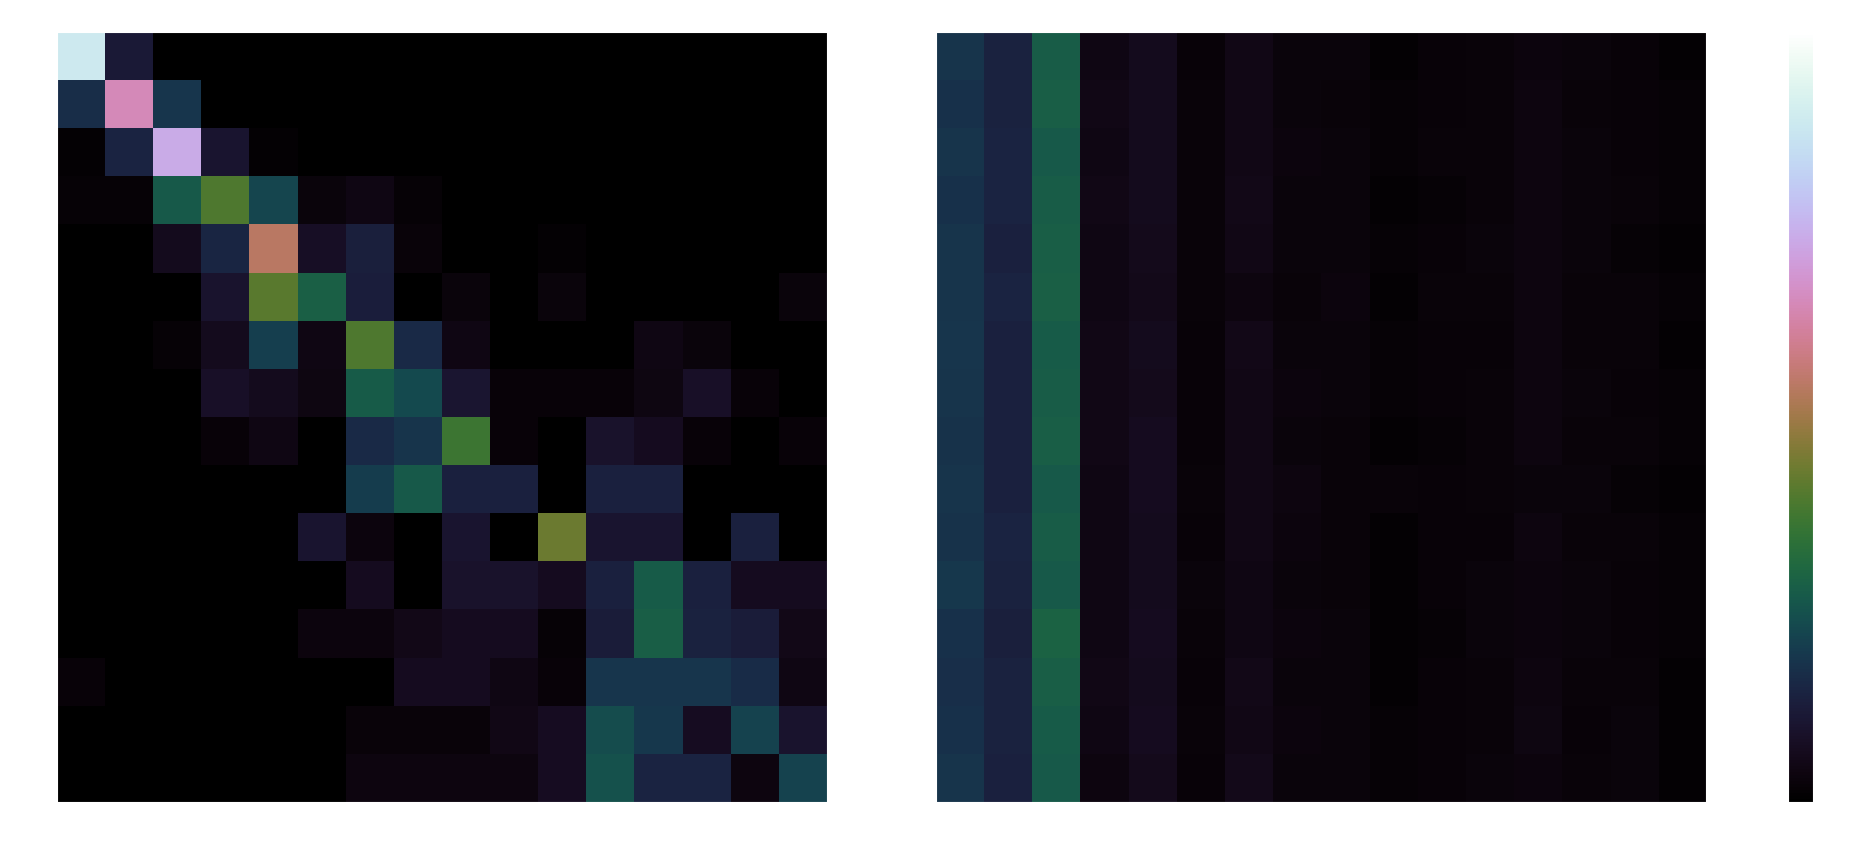

In [135]:
# plot confusion matrix
decoder ='long_age_decoder_males_months'
plot_cm(ymale,y_pred,ysh,ysh_predict,decoder+'_confusion')

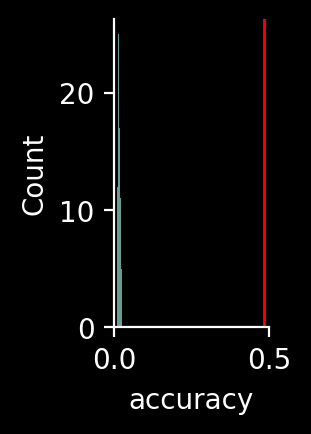

In [136]:
fig = plt.figure(figsize=(1, 2))
fig.dpi = 200
ax = sns.histplot(data=shuff_v['shacc'], fill=True, element='step', lw=0)
ax.axvline(acc, color='r', lw=1)
#plt.xticks(ticks=[])
ax.set(ylabel='Count')
ax.set(xlabel='accuracy')
plt.xlim([0,0.5])
sns.despine()
fig.savefig(data_loc +decoder+'accuracy.pdf', bbox_inches='tight')

In [24]:
## plot decoder over weeks/months by averaging the data

In [31]:
days =mdf.index.get_level_values(0).to_numpy()
wks = np.floor(days/7).astype(int)
df_wks = mdf.copy()
df_wks['wks'] = wks
df_wks = df_wks.groupby(['wks','mouse']).mean()

In [32]:
ymale = df_wks.index.get_level_values(0).to_numpy()
Xmale= df_wks.to_numpy()
Xmale = np.log(Xmale + 1e-6) # convert to linear

In [33]:
#for males
y_pred = cross_val_predict(clf, Xmale, ymale, cv=cv)
acc=np.mean(np.mean(cross_val_score(clf, Xmale, ymale, cv=cv)))
ysh_score=[]
ysh=[]
ysh_predict=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(ymale)
    y_pred_temp = cross_val_predict(clf, Xmale, ysh_temp, cv=cv)
    y_score_temp = cross_val_score(clf, Xmale, ysh_temp, cv=cv)
    ysh.extend(ysh_temp)
    ysh_predict.extend(y_pred_temp)
    ysh_score.append(np.mean(y_score_temp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.71s/it]


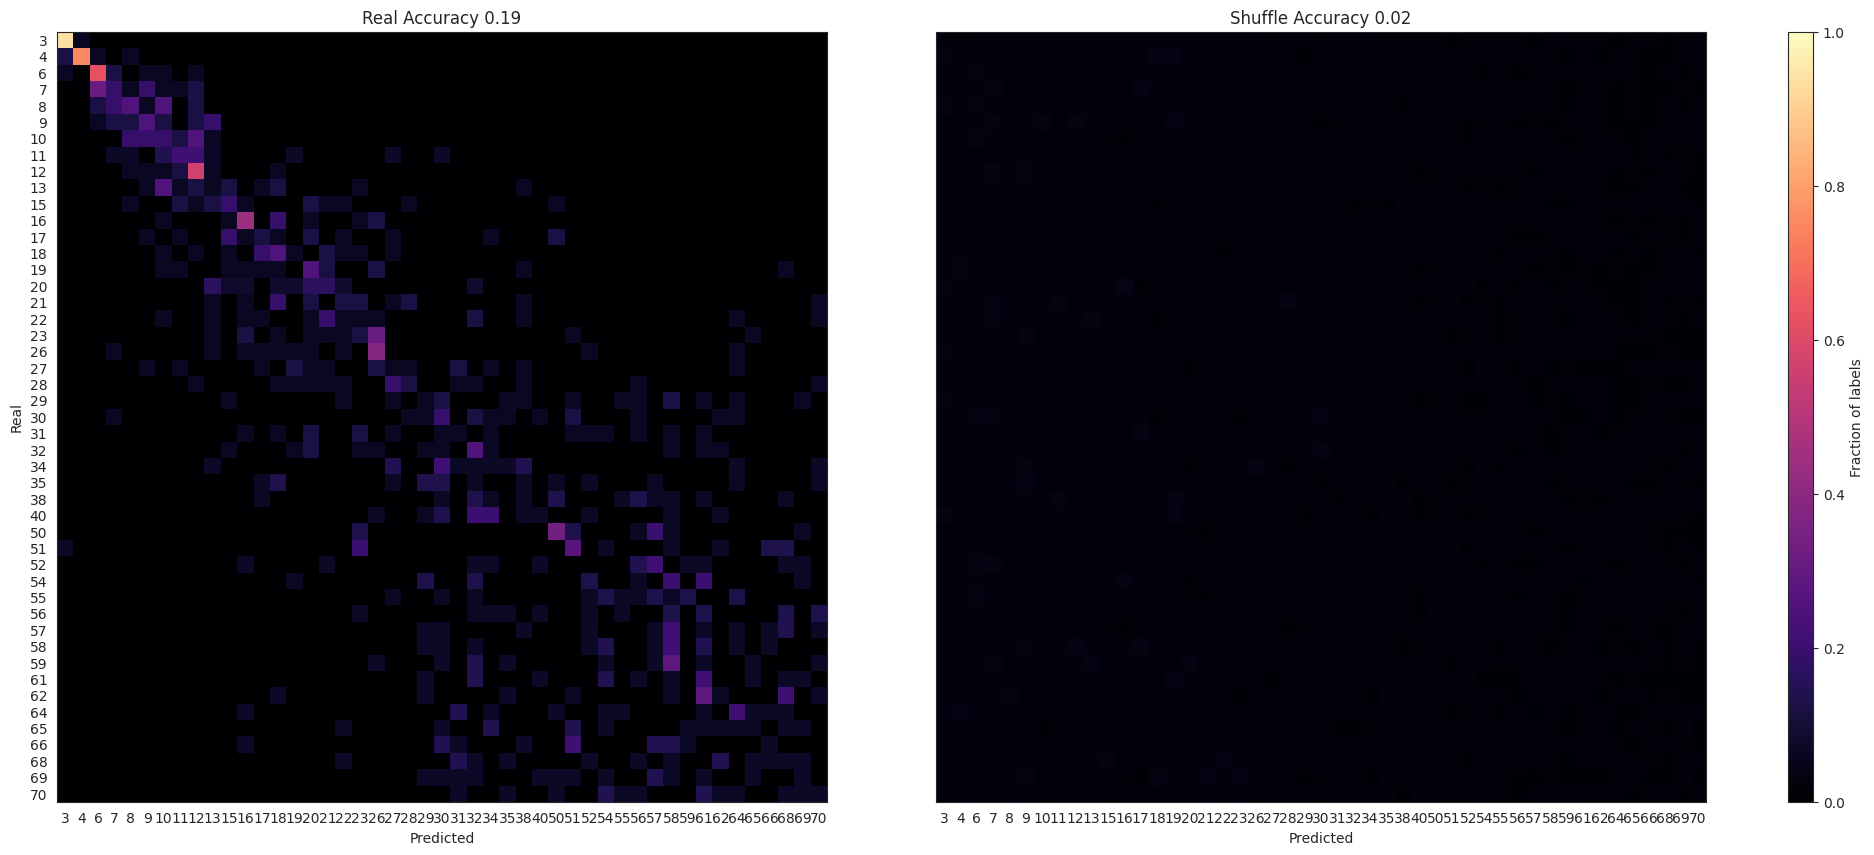

In [34]:
# plot confusion matrix
decoder ='age_decoder_males_wks'
plot_cm(ymale,y_pred,ysh,ysh_predict,decoder+'_confusion')

In [41]:
days =mdf.index.get_level_values(0).to_numpy()
months = np.ceil(days/30).astype(int)
df_months = mdf.copy()
df_months['months'] = months
df_months = df_months.groupby(['months','mouse']).mean()

In [42]:
ymale = df_months.index.get_level_values(0).to_numpy()
Xmale= df_months.to_numpy()
Xmale = np.log(Xmale + 1e-6) # convert to linear

In [43]:
#for males
y_pred = cross_val_predict(clf, Xmale, ymale, cv=cv)
acc=np.mean(np.mean(cross_val_score(clf, Xmale, ymale, cv=cv)))
ysh_score=[]
ysh=[]
ysh_predict=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(ymale)
    y_pred_temp = cross_val_predict(clf, Xmale, ysh_temp, cv=cv)
    y_score_temp = cross_val_score(clf, Xmale, ysh_temp, cv=cv)
    ysh.extend(ysh_temp)
    ysh_predict.extend(y_pred_temp)
    ysh_score.append(np.mean(y_score_temp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.88it/s]


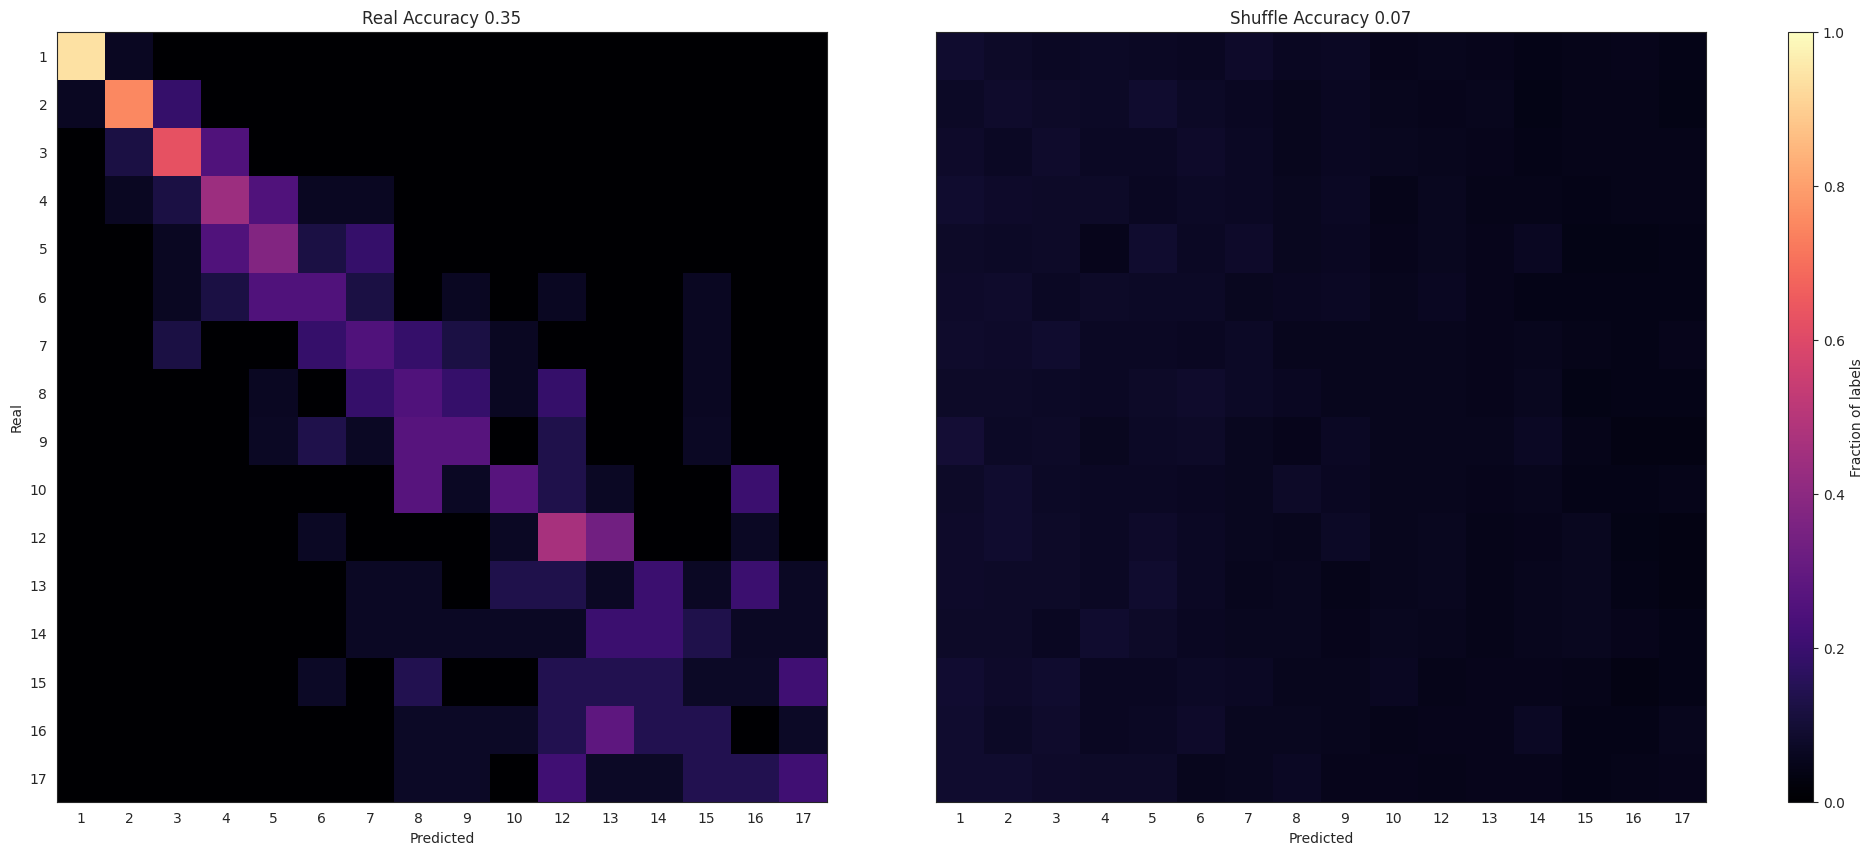

In [44]:
# plot confusion matrix
decoder ='age_decoder_males_months'
plot_cm(ymale,y_pred,ysh,ysh_predict,decoder+'_confusion')

In [ ]:
bins = [0, 1, 5, 10, 25, 50, 100]
labels = [1,2,3,4,5,6]
df['binned'] = pd.cut(df['percentage'], bins=bins, labels=labels)
print (df)
   percentage binned
0       46.50      5
1       44.20      5
2      100.00      6
3       42.12      5